# Unsupervised Learning Problem Description and Data

Smart home devices are increasingly common in homes, given their convenience for home owners, and the advent of technology. However, given that smart home devices may need to be used frequently, it is also important to know how efficient they are.

As a soon-to-be home owner myself, I have been looking at smart home devices for my new home. I came across this dataset on Kaggle on smart home device usage metrics, which offers insights into the device efficiency. I thought this project would present an interesting opportunity to understand that features that are relevant to a device's efficiency and the usage patterns of these devices, which could provide useful insights on smart home device usage for those who may have or wish to buy smart home devices.

Data source: [Kaggle link](https://www.kaggle.com/datasets/rabieelkharoua/predict-smart-home-device-efficiency-dataset/data)

I will first import the necessary libraries that are needed for the analysis.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
df = pd.read_csv('/content/drive/MyDrive/DTSA5510/smart_home_device_usage_data.csv')
print(df.shape)
df.head()

(5403, 8)


,UserID,DeviceType,UsageHoursPerDay,EnergyConsumption,UserPreferences,MalfunctionIncidents,DeviceAgeMonths,SmartHomeEfficiency
0,1,Smart Speaker,15.307188,1.961607,1,4,36,1
1,2,Camera,19.973343,8.610689,1,0,29,1
2,3,Security System,18.911535,2.651777,1,0,20,1
3,4,Camera,7.011127,2.341653,0,3,15,0
4,5,Camera,22.610684,4.859069,1,3,36,1


We can see that the dataset has 5,403 data points, and 8 columns. The target variable of "SmartHomeEfficiency" has a value of 1 for being efficient, and a value of 0 for inefficient. The features include device type, usage hours per day, energy consumption, number of malfunction incidents and age of the device (in months).

In [4]:
df.describe()

,UserID,UsageHoursPerDay,EnergyConsumption,UserPreferences,MalfunctionIncidents,DeviceAgeMonths,SmartHomeEfficiency
count,5403.000000,5403.000000,5403.000000,5403.000000,5403.000000,5403.000000,5403.000000
mean,2702.000000,12.052992,5.054302,0.511753,2.066445,30.312234,0.376643
std,1559.856083,6.714961,2.878941,0.499908,1.423291,16.990525,0.484589
min,1.000000,0.501241,0.101562,0.000000,0.000000,1.000000,0.000000
25%,1351.500000,6.297871,2.524968,0.000000,1.000000,15.000000,0.000000
50%,2702.000000,11.903768,5.007047,1.000000,2.000000,30.000000,0.000000
75%,4052.500000,17.791751,7.611912,1.000000,3.000000,45.000000,1.000000
max,5403.000000,23.987326,9.998071,1.000000,4.000000,59.000000,1.000000


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5403 entries, 0 to 5402
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   UserID                5403 non-null   int64  
 1   DeviceType            5403 non-null   object 
 2   UsageHoursPerDay      5403 non-null   float64
 3   EnergyConsumption     5403 non-null   float64
 4   UserPreferences       5403 non-null   int64  
 5   MalfunctionIncidents  5403 non-null   int64  
 6   DeviceAgeMonths       5403 non-null   int64  
 7   SmartHomeEfficiency   5403 non-null   int64  
dtypes: float64(2), int64(5), object(1)
memory usage: 337.8+ KB


We can see that all the variables are numerical, except for device type, which is a categorical variable.

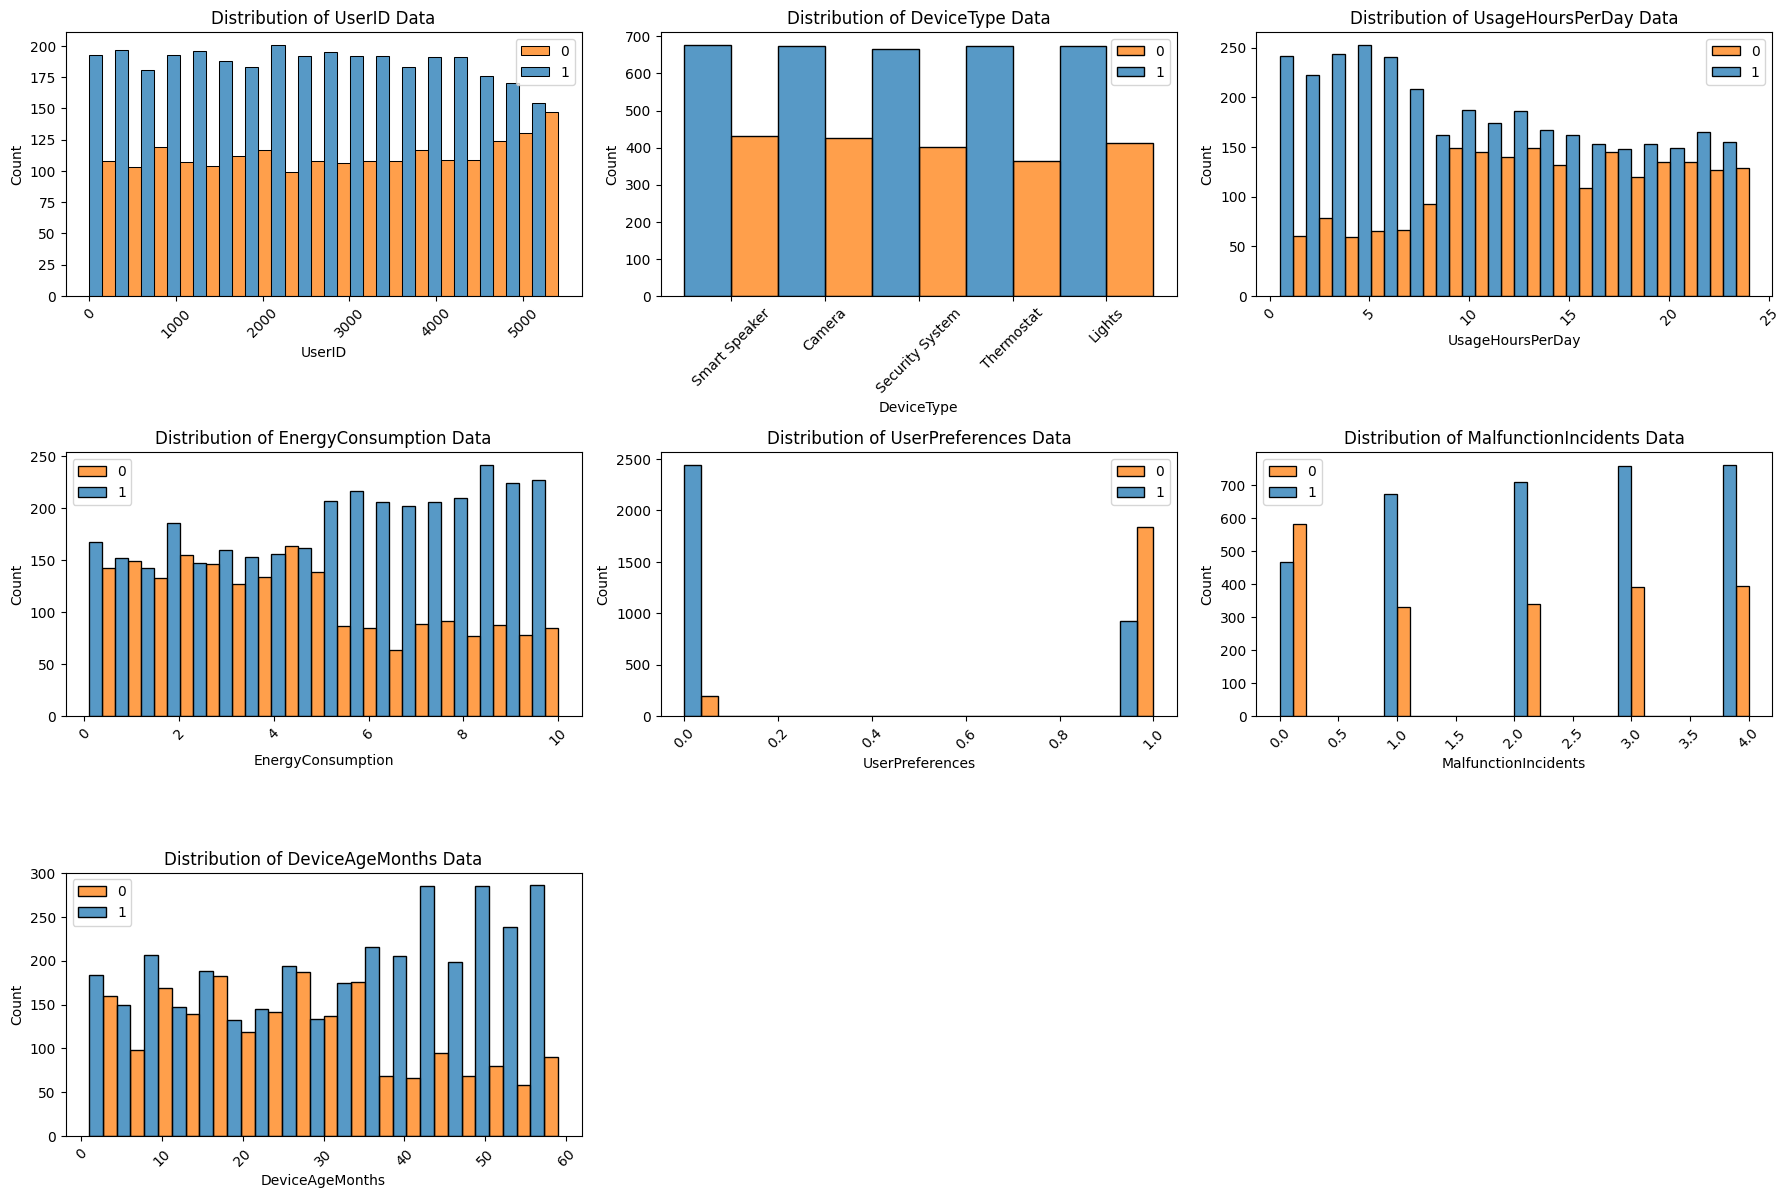

In [6]:
plt.figure(figsize = (18, 12))
num_cols = len(df.columns[:-1])
num_rows = (num_cols + 2)//3

for i, col in enumerate(df.columns[:-1], 1):
    plt.subplot(num_rows, 3, i)
    sns.histplot(x = df[col], hue = df["SmartHomeEfficiency"], multiple = "dodge")
    plt.title(f"Distribution of {col} Data")
    plt.tight_layout()
    plt.xticks(rotation = 45)
    plt.legend(["0", "1"])
    plt.plot()

From the histogram plots of the features, we can make the following observations:
1. There are five types of smart home devices present in this dataset and there is a higher number of efficient devices as compared to inefficent ones.
2. Users generally used efficient smart home devices for longer period of time than inefficient ones, since the device age months is much higher.
3. While I would think that the energy consumption data would be lower for efficient devices, the graph does not seem to show that. However, it could also be that users are using it for longer hours, which would result in more energy consumption. Perhaps a better variable to look at would be the energy consumption/hour.

#Data Preprocessing

I will drop the UserID variable, as it is not a relevant feature in the efficiency of the device. I will also drop the "SmartHomeEfficiency" variable first, because I want to do some unsupervised learning, and hence I will attempt to cluster the datapoints and see if they can be grouped into two clusters for efficient and not efficient devices. As mentioned earlier, perhaps energy consumption/hour would be a better variable, hence I have added the variable.  

In [7]:
#Keep y values first
y = df['SmartHomeEfficiency'].values

df_features = df.drop(columns=["UserID", "SmartHomeEfficiency"])

# Convert categorical features
df_features = pd.get_dummies(df_features)

# Handle missing values if necessary
df_features = df_features.dropna()

In [8]:
df_features['EnergyPerHour'] = df['EnergyConsumption'] / df['UsageHoursPerDay']

In [9]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df_features)

#Unsupervised Validation with Labelled data

As I know that the devices are either labelled as 0 for not efficient and 1 for efficient, I will attempt Kmeans clustering to see if my data points can be separated into two distinct clusters, to see if natural patterns in smart home device usage align with the known efficiency labels.

In [10]:
kmeans = KMeans(n_clusters=2, random_state=1108)
predicted_clusters = kmeans.fit_predict(scaled_data)

In [12]:
cm1 = confusion_matrix(y, predicted_clusters)
cm2 = confusion_matrix(y, 1 - predicted_clusters)  # flipped

acc1 = accuracy_score(y, predicted_clusters)
acc2 = accuracy_score(y, 1 - predicted_clusters)

print("Accuracy (original mapping):", acc1)
print("Accuracy (flipped mapping):", acc2)
print("Confusion Matrix (best match):")
print(cm1 if acc1 > acc2 else cm2)

Accuracy (original mapping): 0.6777716083657227
Accuracy (flipped mapping): 0.32222839163427724
Confusion Matrix (best match):
[[2147 1221]
 [ 520 1515]]


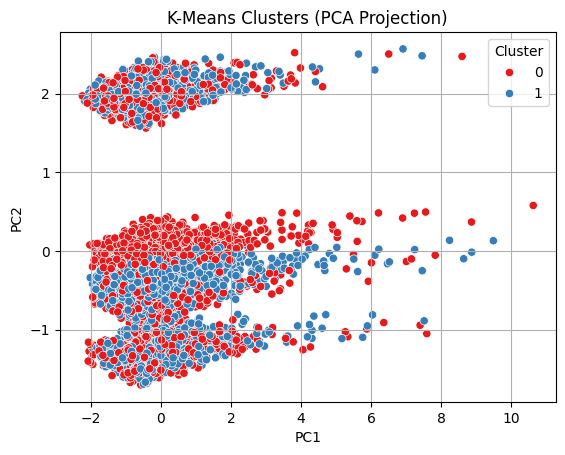

In [13]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled_data)

pca_df = pd.DataFrame(pca_result, columns=['PC1', 'PC2'])
pca_df['Cluster'] = predicted_clusters
pca_df['TrueEfficiency'] = y

sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='Cluster', palette='Set1')
plt.title("K-Means Clusters (PCA Projection)")
plt.grid(True)
plt.show()

From the above visualisation of the Kmeans clustering, we can see that the clustering does not align well with efficiency, hence it does not show strong natural grouping in the data. This would suggest that additional features or supervised learning are actually needed to distinguish efficiency.

Just to test, I tried to see what would be the optimal number of clusters. From the elbow plot below, the optimal number would seem to be 5 (the point where the line starts to bend, like an elbow).

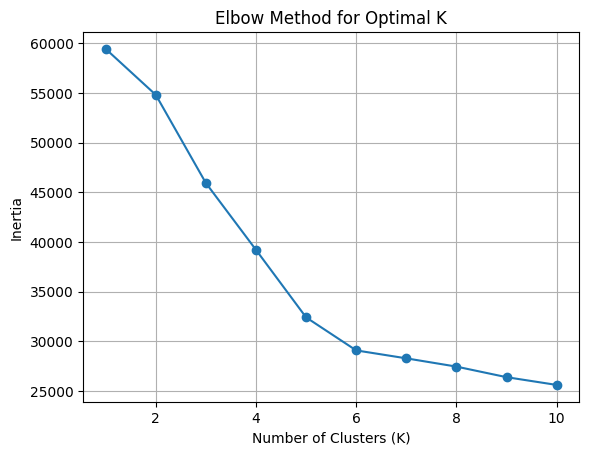

In [17]:
inertia = []
K_range = range(1, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=1108)
    kmeans.fit(scaled_data)
    inertia.append(kmeans.inertia_)

plt.plot(K_range, inertia, marker='o')
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Inertia")
plt.title("Elbow Method for Optimal K")
plt.grid(True)
plt.show()

In [19]:
kmeans = KMeans(n_clusters=5, random_state=1108)
clusters = kmeans.fit_predict(scaled_data)

df['Cluster'] = clusters

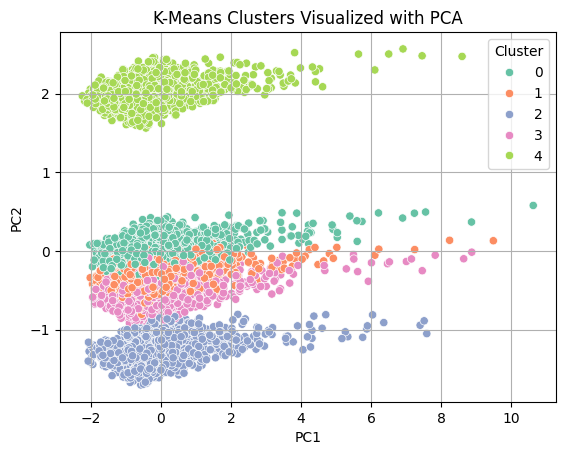

In [20]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled_data)

pca_df = pd.DataFrame(pca_result, columns=["PC1", "PC2"])
pca_df['Cluster'] = clusters
pca_df['Efficiency'] = df['SmartHomeEfficiency']

sns.scatterplot(data=pca_df, x="PC1", y="PC2", hue="Cluster", palette="Set2")
plt.title("K-Means Clusters Visualized with PCA")
plt.grid(True)
plt.show()

Based on the weight of the features, we can see that the important features in predicting efficiency would be the energy per hour, as what we would expect logically.

In [21]:
pca = PCA()
pca.fit(scaled_data)
loadings = pd.DataFrame(pca.components_[0], index=df_features.columns, columns=['PC1 Weight'])
print(loadings.sort_values('PC1 Weight', key=abs, ascending=False))

                            PC1 Weight
EnergyPerHour                 0.710627
UsageHoursPerDay             -0.586366
EnergyConsumption             0.376071
DeviceAgeMonths              -0.060523
DeviceType_Smart Speaker     -0.057961
UserPreferences               0.032763
DeviceType_Lights             0.025963
MalfunctionIncidents         -0.022529
DeviceType_Thermostat         0.019835
DeviceType_Security System    0.006629
DeviceType_Camera             0.006297


#KMeans vs Logistic Regression

I also wanted to compare the supervised and unsupervised learning methods.I will split the dataset so I can test the model and compare the accuracy.

In [22]:
X_train, X_test, y_train, y_test = train_test_split(scaled_data, y, test_size=0.2, random_state=1108)

In [23]:
from sklearn.linear_model import LogisticRegression

reg = LogisticRegression()
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)

logreg_acc = accuracy_score(y_test, y_pred)

In [24]:
kmeans = KMeans(n_clusters=2, random_state=1108)
clusters = kmeans.fit_predict(X_train)

In [26]:
acc1 = accuracy_score(y_train, clusters)
acc2 = accuracy_score(y_train, 1 - clusters)

kmeans_acc = max(acc1, acc2)

In [27]:
print(f"\n Summary:")
print(f"Supervised Logistic Regression Accuracy: {logreg_acc:.2f}")
print(f"Unsupervised KMeans Clustering Accuracy: {kmeans_acc:.2f}")


 Summary:
Supervised Logistic Regression Accuracy: 0.86
Unsupervised KMeans Clustering Accuracy: 0.57


In this context, it was not unexpected that the supervised logistic regression model performed better than KMeans clustering, given that the features do not naturally cluster by efficiency. It was however still insightful to see how KMeans clustering worked.

For future research, it would be good if we could explore within device type and run the clustering separately for each Ddevice type to see if efficiency patterns are clearer within homogeneous groups. I would also be interested to see if other supervised methods could perform better than the logistic regression method.

Resources:

- ChatGPT
- Google Colab (for helping to debug)
- [Kaggle](https://https://www.kaggle.com/code/iamdebjitmandal/smart-home-device-usage-analysis#Data-Preprocessing)